In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ser = pd.read_csv('G:/1.__Datasets__/daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True, skipfooter=2, engine='python')

# To clean data from unexpected characters 
def rem_chars(str):
    return float(''.join([x for x in str if x.isnumeric() or x == '.']))

# Cleaning the series permanently
ser = ser.apply(rem_chars)


dataframe = pd.DataFrame(ser)
dataframe

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


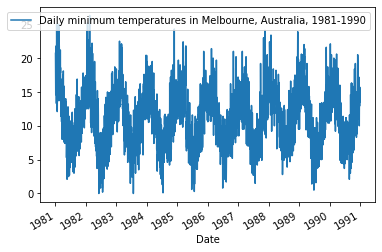

In [2]:
dataframe.plot()

### Applying Kmeans

MSE:  0.09322278084570518
Random MSE:  80.63712602739726


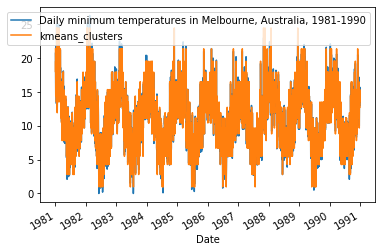

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

n_clusters = 20

kmeans   = KMeans(n_clusters=n_clusters, random_state=0).fit(dataframe.values)
dataframe['kmeans_clusters'] = kmeans.cluster_centers_.squeeze()[kmeans.predict(dataframe.values)]


_ = dataframe.plot()


print('MSE: ',mean_squared_error(dataframe.iloc[:,0],dataframe.iloc[:,1]))
## Let's compare that to 20 points selected from the time series and assigned randomly to each data point
### Choosing 20 points
n_random_points  = np.random.permutation(dataframe.iloc[:,0].values[:20])
### Assign a random point out of the 20 to each datapoint in the ts
random_component = np.random.choice(n_random_points,dataframe.shape[0])
print('Random MSE: ',mean_squared_error(dataframe.iloc[:,0],random_component))

- 20 clusters is a reasonable number of clusters to approximate the time series.
- A huge improvement over random in MSE.

In [4]:
# Removing the column 
dataframe.drop('kmeans_clusters',axis = 1, inplace = True)

### DTW vs Euclidean

In [5]:
# Create a shifted version of the dataframe
dataframe_shifted = dataframe[10:]
print(dataframe.head())
print(dataframe_shifted.head())
print()

# Let's Measure MSE
## taking into consideration the equal-in-length must.
print('MSE: ',mean_squared_error(dataframe[:-10],dataframe_shifted))

            Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                     
1981-01-01                                               20.7            
1981-01-02                                               17.9            
1981-01-03                                               18.8            
1981-01-04                                               14.6            
1981-01-05                                               15.8            
            Daily minimum temperatures in Melbourne, Australia, 1981-1990
Date                                                                     
1981-01-11                                               16.2            
1981-01-12                                               13.3            
1981-01-13                                               16.7            
1981-01-14                                               21.5            
1981-01-15                            

- A huge MSE regardless of the fact that the second is just a shifted version of the first.
- The reason for this is that Euclidean distance measures the MSE between every datapoint and the corresponding datapoint index in the other ts.
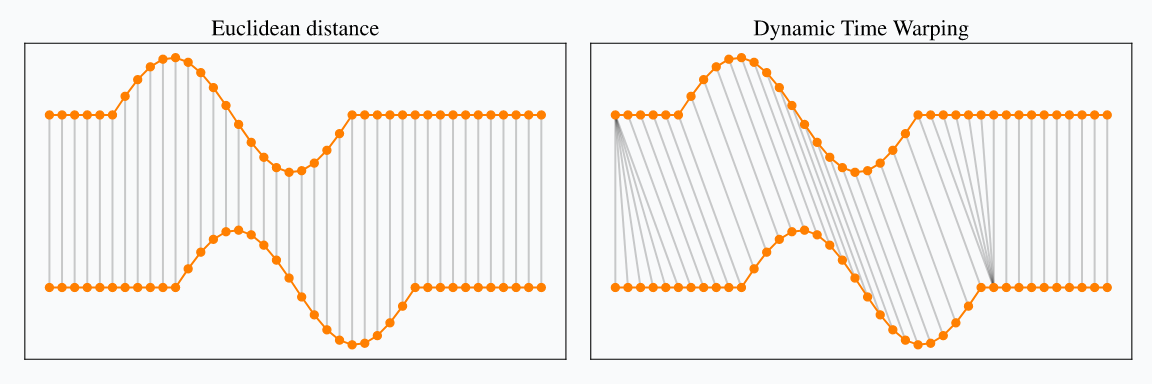

In [6]:
# Let's move towards implenting DTW
def dtw_distance_matrix(ts1,ts2):
    ts1_len = ts1.__len__()
    ts2_len = ts2.__len__()
    
    D = np.zeros((ts1_len+1 , ts2_len+1))
    
    for i in range(1,ts1_len+1):
        for j in range(1,ts2_len+1):
            D[i,j] = np.power(ts1[i-1] - ts2[j-1],2) + min(
                D[i-1,j-1],
                D[i,j-1],
                D[i-1,j],
            )
    
    return D[1:,1:]

# Build the distance matrix
dtw_D = dtw_distance_matrix(dataframe.values.squeeze(),dataframe_shifted.values.squeeze())
dtw_D

array([[20.25, 54.76, 16.  , ..., 51.84, 25.  , 59.29],
       [ 2.89, 24.05, 17.44, ..., 69.77, 29.84, 49.01],
       [ 6.76, 33.14, 21.85, ..., 91.47, 39.45, 63.48],
       ...,
       [ 7.29,  3.18, 13.38, ...,  0.  ,  4.84,  3.91],
       [ 0.25,  6.01,  4.18, ...,  4.84,  0.  ,  7.29],
       [10.24,  0.34, 14.03, ...,  3.91,  7.29,  0.  ]])

In [7]:
def dtw_shortest_path(D):
    A_paths = np.zeros_like(D)
    
    i = D.shape[0] - 1
    j = D.shape[1] - 1
    
    while i>=0 and j>=0:
        A_paths[i,j] = 1
        
        min_ind = np.argmin([
            D[i-1,j-1],
            D[i  ,j-1],
            D[i-1,j  ]
        ])
        
        if   min_ind == 0:
            i-=1 ; j-=1 
        elif min_ind == 1:
            j-=1
        else:
            i-=1
        
    return A_paths,np.sqrt(np.sum(D * A_paths))


A_paths, dtw_score_ = dtw_shortest_path(dtw_D)
dtw_score_

8.954328562209454

In [8]:
from tslearn.metrics import dtw

dtw_score = dtw(dataframe.values.squeeze(),dataframe_shifted.values.squeeze())
dtw_score

8.954328562209453

Same result but with huge difference in time.

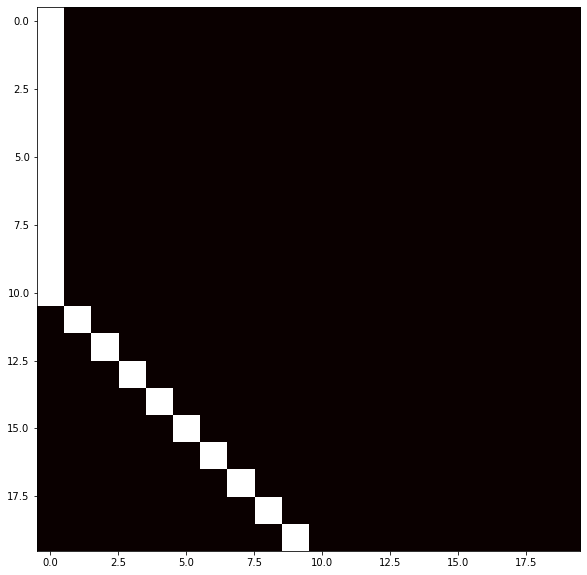

In [24]:
# Plotting the paths
figure = plt.figure(figsize = (10,10))
plt.imshow(A_paths[:20,:20], cmap='hot', interpolation='nearest')
plt.show()

You can see that the first couple of point of the original TS that were removed from the shifted TS are all mapped to the first point of the shifted TS. After that the matrix is diagonal **(every point is mapped to itself)**.

In [12]:
A_paths

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])